Best Parameters: {'colsample_bytree': 0.8, 'eta': 0.2, 'max_depth': 2, 'subsample': 0.6}


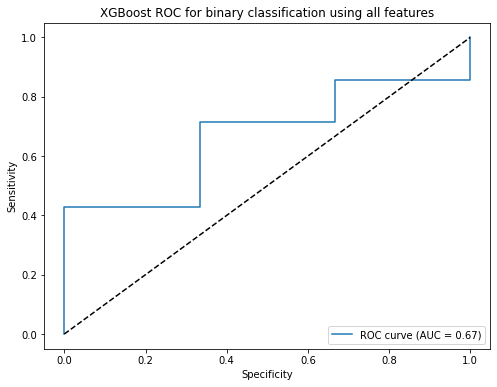

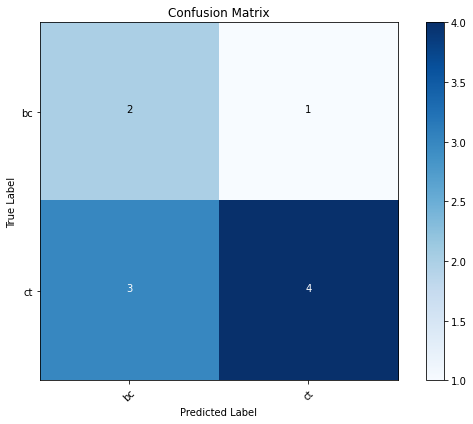

Classification Report:
              precision    recall  f1-score   support

          bc       0.40      0.67      0.50         3
          ct       0.80      0.57      0.67         7

    accuracy                           0.60        10
   macro avg       0.60      0.62      0.58        10
weighted avg       0.68      0.60      0.62        10



In [30]:
#XGBoost for binary classification using all numeric features
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, concatenate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

tsv_file_path = 'Data_SHG_FINAL.tsv'
df = pd.read_csv(tsv_file_path, sep='\t')

# Select columns to use as features
feature_columns = [
    'Red-Transformed', 'Blue-Transformed', 'Green-Transformed', 'Pink-Transformed',
    'All_pixels-Transformed-AROI', 'Pixel_containing_Collagen-Transformed_(Red+Pink)',
    'Number_of_Red_pixel_(Original)', 'Intensity-Mean-Red-Original_(1-254)',
    'Number_of_Green_pixel_(Original)', 'I_cn=Intensity-Mean-Green-Original_(1-254)',
    'Collagen%_Transformed_image_((Red+pink)/Total)',
    'Area_of_Skeleton_All_colors_Transformed', 'Area_of_Skeleton_of_Collagen_(Red+Pink)_Transformed',
    'NBP(Number_of_Branchpoints_of_Collagen)_Transformed',
    'Cn_(No_of_pixels_with_Collagen_(Red+Pink))_Transformed',
    'CA_or_ACn_(Collagen_area_in_um^2)_Transformed',
    'Number_of_unsaturated_pixels_(Green)Aucn', 'Total_Number_of_Pixels_of_Green',
    'Number_of_saturated_green_pixels_(AQ_AP)', 'Intensity_of_Unsaturated_Pixel_UCFD',
    'Intensity_Saturated_Pixel_CFD', 'CAR_(Collagen_Area_Ratio=Collagen%)',
    'CRI_(Collagen_Reticulation_Index)', 'CARD_(Collagen_Area_Reticulation_Density)',
    'Total_Number_of_Collagen_Fibers', 'Median_of_Fiber_Orientation_(Angle)',
    'Median_of_Fiber_Length', 'Median_of_Fiber_Width', 'Long_Fibers', 'Short_Fibers',
    'Thick_Fibers_(Max_Width)', 'Thin_Fibers_(Min_Width)', 'Ratio_of_Long_Fibers',
    'Ratio_of_Short_Fibers', 'Ratio_of_Thick_Fibers', 'Ratio_of_Thin_Fibers'
]

# Separate features (X) and target variable (y)
I = df[feature_columns]
y = df['binary_group']
image_paths = df['image_path']

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(I)

# Convert class labels to binary matrix using LabelBinarizer
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

# Concatenate image and numerical features
x = np.concatenate([flattened_image_features, X_normalized], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y_binary, test_size=0.2, random_state=42
)

# Train XGBoost model
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param_grid = {
    # 'max_depth': [3, 6, 9],
    'max_depth': [2],
    # 'eta': [0.1, 0.2, 0.3],
    'eta': [0.2],
    # 'subsample': [0.6, 0.8, 1.0],
    'subsample': [0.6],
    # 'colsample_bytree': [0.6, 0.8, 1.0]
    'colsample_bytree': [0.8]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_log_loss')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Get predicted probabilities
y_pred_prob = grid_search.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('XGBoost ROC for binary classification using all features')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred = np.round(y_pred_prob)

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')



# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))

Best Parameters: {'colsample_bytree': 0.8, 'eta': 0.2, 'max_depth': 2, 'subsample': 0.6}


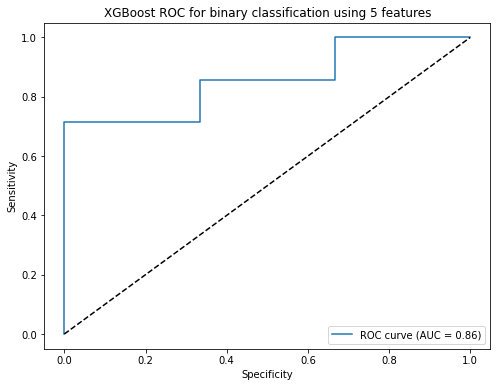

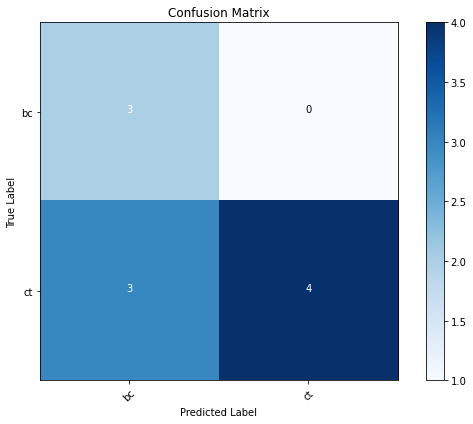

Classification Report:
              precision    recall  f1-score   support

          bc       0.50      1.00      0.67         3
          ct       1.00      0.57      0.73         7

    accuracy                           0.70        10
   macro avg       0.75      0.79      0.70        10
weighted avg       0.85      0.70      0.71        10



In [31]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, concatenate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Read the Excel spreadsheet
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['binary_group'].values[1:]

# Convert class labels to binary matrix using LabelBinarizer
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_string).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

# # Flatten image features
# flattened_image_features = Flatten()(image_features)

# Preprocess numerical data (similar to image preprocessing)
# num_features = num_features.astype(np.float32)
# num_features /= num_features.max(axis=0)

# Concatenate image and numerical features
x = np.concatenate([flattened_image_features, num_features], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y_binary, test_size=0.2, random_state=42
)

# Train XGBoost model
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# params = {
#     'max_depth': 6,
#     'eta': 0.3,
#     'objective': 'binary:logistic',
#     'eval_metric': 'logloss',
#     'subsample': 0.8,
#     'colsample_bytree': 0.8
# }

# num_rounds = 100
# xgb_model = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'eval')], early_stopping_rounds=10)

# Best Parameters: {'colsample_bytree': 0.8, 'eta': 0.2, 'max_depth': 3, 'subsample': 0.6}
# Best Parameters: {'colsample_bytree': 0.8, 'eta': 0.2, 'max_depth': 2, 'subsample': 0.6}

param_grid = {
    # 'max_depth': [3, 6, 9],
    'max_depth': [2],
    # 'eta': [0.1, 0.2, 0.3],
    'eta': [0.2],
    # 'subsample': [0.6, 0.8, 1.0],
    'subsample': [0.6],
    # 'colsample_bytree': [0.6, 0.8, 1.0]
    'colsample_bytree': [0.8]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_log_loss')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Get predicted probabilities
y_pred_prob = grid_search.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('XGBoost ROC for binary classification using 5 features')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred = np.round(y_pred_prob)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


cm = confusion_matrix(y_test, y_pred)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))

Best Parameters: {'colsample_bytree': 0.8, 'eta': 0.2, 'max_depth': 2, 'subsample': 0.6}


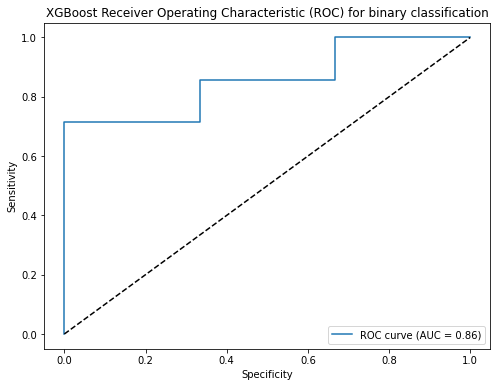

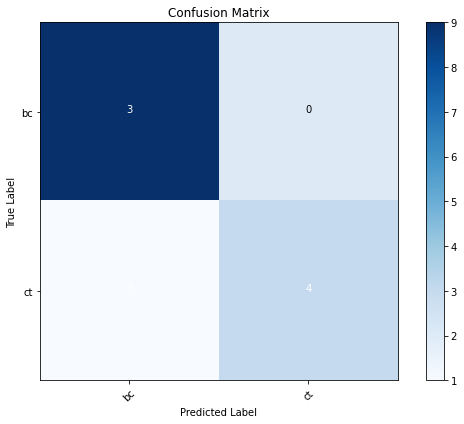

Classification Report:
              precision    recall  f1-score   support

          bc       0.50      1.00      0.67         3
          ct       1.00      0.57      0.73         7

    accuracy                           0.70        10
   macro avg       0.75      0.79      0.70        10
weighted avg       0.85      0.70      0.71        10



In [13]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, concatenate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Read the Excel spreadsheet
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['binary_group'].values[1:]

# Convert class labels to binary matrix using LabelBinarizer
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_string).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

# # Flatten image features
# flattened_image_features = Flatten()(image_features)

# Preprocess numerical data (similar to image preprocessing)
# num_features = num_features.astype(np.float32)
# num_features /= num_features.max(axis=0)

# Concatenate image and numerical features
x = np.concatenate([flattened_image_features, num_features], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y_binary, test_size=0.2, random_state=42
)

# Train XGBoost model
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# params = {
#     'max_depth': 6,
#     'eta': 0.3,
#     'objective': 'binary:logistic',
#     'eval_metric': 'logloss',
#     'subsample': 0.8,
#     'colsample_bytree': 0.8
# }

# num_rounds = 100
# xgb_model = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'eval')], early_stopping_rounds=10)

# Best Parameters: {'colsample_bytree': 0.8, 'eta': 0.2, 'max_depth': 3, 'subsample': 0.6}
# Best Parameters: {'colsample_bytree': 0.8, 'eta': 0.2, 'max_depth': 2, 'subsample': 0.6}

param_grid = {
    # 'max_depth': [3, 6, 9],
    'max_depth': [2],
    # 'eta': [0.1, 0.2, 0.3],
    'eta': [0.2],
    # 'subsample': [0.6, 0.8, 1.0],
    'subsample': [0.6],
    # 'colsample_bytree': [0.6, 0.8, 1.0]
    'colsample_bytree': [0.8]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_log_loss')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Get predicted probabilities
y_pred_prob = grid_search.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('XGBoost Receiver Operating Characteristic (ROC) for binary classification')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred = np.round(y_pred_prob)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


cm = confusion_matrix(y_test, y_pred)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))

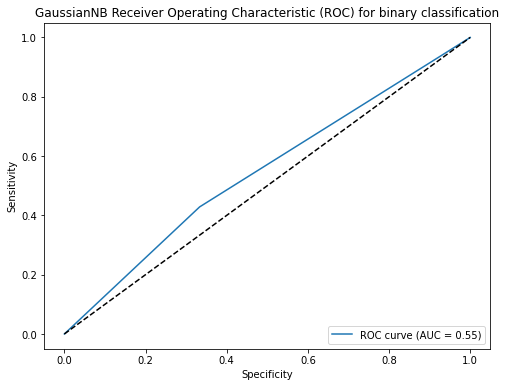

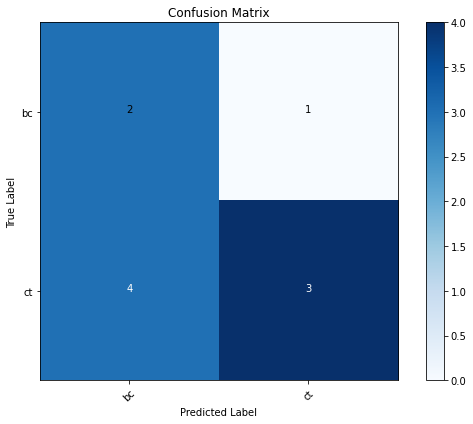

Classification Report:
              precision    recall  f1-score   support

          bc       0.33      0.67      0.44         3
          ct       0.75      0.43      0.55         7

    accuracy                           0.50        10
   macro avg       0.54      0.55      0.49        10
weighted avg       0.62      0.50      0.52        10



In [14]:
#GaussianNB model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['binary_group'].values[1:]

# Convert class labels to binary matrix using LabelBinarizer
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_string).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

# # Flatten image features
# flattened_image_features = Flatten()(image_features)

# Preprocess numerical data (similar to image preprocessing)
# num_features = num_features.astype(np.float32)
# num_features /= num_features.max(axis=0)

# Concatenate image and numerical features
x = np.concatenate([flattened_image_features, num_features], axis=1)




# Number of runs for averaging results
num_runs = 10

# Initialize list to store AUC values for each class
auc_values = [[] for _ in range(len(set(y_string)))]

# Parameters for model training
#random_state = 42

# Loop for multiple runs
# for _ in range(num_runs):
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y_binary, test_size=0.2, random_state=42)

# Convert class labels to numerical labels
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)
# num_classes = len(label_encoder.classes_)

# Create a Naive Bayes classifier
model = GaussianNB()

# Train the model
model.fit(X_train, y_train)

# Predict probabilities for each class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('GaussianNB Receiver Operating Characteristic (ROC) for binary classification')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred = np.round(y_pred_prob)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


cm = confusion_matrix(y_test, y_pred)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))

# # Calculate mean ROC curve for each class
# mean_fpr_tpr = []
# for class_index in range(num_classes):
#     fpr_values = []
#     tpr_values = []
#     for fpr, tpr in auc_values[class_index]:
#         interp_tpr = np.interp(mean_fpr, fpr, tpr)
#         fpr_values.append(mean_fpr)
#         tpr_values.append(interp_tpr)
#     mean_tpr = np.mean(tpr_values, axis=0)
#     mean_auc = auc(mean_fpr, mean_tpr)
#     mean_fpr_tpr.append((mean_fpr, mean_tpr))


# Plot mean ROC curves for each class
# plt.figure(figsize=(8, 6))
# for class_index, (mean_fpr, mean_tpr) in enumerate(mean_fpr_tpr):
#     mean_auc = auc(mean_fpr, mean_tpr)
#     plt.plot([0] + list(mean_fpr), [0] + list(mean_tpr), lw=2, label='ROC curve for class {} (AUC = {:.2f})'.format(class_index, mean_auc))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('Specificity')
# plt.ylabel('Sensitivity')
# plt.title('ROC curves for each class using GaussianNB')
# plt.legend(loc="lower right")
# plt.show()

# # Initialize an empty array to store binary predictions for each class
# all_pred_binary = []

# # Threshold the predicted probabilities for each class separately
# for class_index in range(num_classes):
#     # Threshold the predicted probabilities to get the predicted labels for the current class
#     y_pred_class_binary = np.argmax(y_pred_prob, axis=1)
#     all_pred_binary.append(y_pred_class_binary)


# # Convert the list of binary predictions to a numpy array
# all_pred_binary = np.array(all_pred_binary)


# # Iterate over each class and plot confusion matrix
# for class_index in range(num_classes):
#     # Filter true and predicted labels for the current class
#     y_true_class = (y_test_encoded == class_index).astype(int)
#     y_pred_class = (y_pred_binary == class_index).astype(int)

#     # Compute confusion matrix
#     cm = confusion_matrix(y_true_class, y_pred_class)

#     # Plot confusion matrix
#     plt.figure(figsize=(4, 4))
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title(f'Confusion Matrix for Class {class_index}')
#     plt.colorbar()

#     # Manually specify tick labels for a 2x2 confusion matrix
#     plt.xticks([0, 1], ['Negative', 'Positive'])
#     plt.yticks([0, 1], ['Negative', 'Positive'])

#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.tight_layout()
#     plt.show()


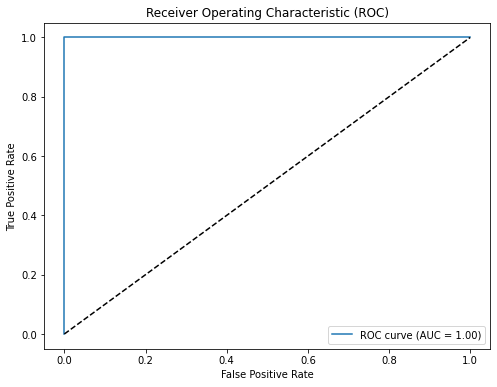

Classification Report:
              precision    recall  f1-score   support

          bc       0.60      1.00      0.75         3
          ct       1.00      0.71      0.83         7

    accuracy                           0.80        10
   macro avg       0.80      0.86      0.79        10
weighted avg       0.88      0.80      0.81        10



In [10]:
#SVM model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['binary_group'].values[1:]

# Convert class labels to binary matrix using LabelBinarizer
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_string).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

# # Flatten image features
# flattened_image_features = Flatten()(image_features)

# Preprocess numerical data (similar to image preprocessing)
# num_features = num_features.astype(np.float32)
# num_features /= num_features.max(axis=0)

# Concatenate image and numerical features
x = np.concatenate([flattened_image_features, num_features], axis=1)




# Number of runs for averaging results
num_runs = 10

# Initialize list to store AUC values for each class
auc_values = [[] for _ in range(len(set(y_string)))]

# Parameters for model training
#random_state = 42

# Loop for multiple runs
# for _ in range(num_runs):
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y_binary, test_size=0.2, random_state=42)

# Convert class labels to numerical labels
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)
# num_classes = len(label_encoder.classes_)

# Create a Naive Bayes classifier
model = SVC(probability=True, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict probabilities for each class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred = np.round(y_pred_prob)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))

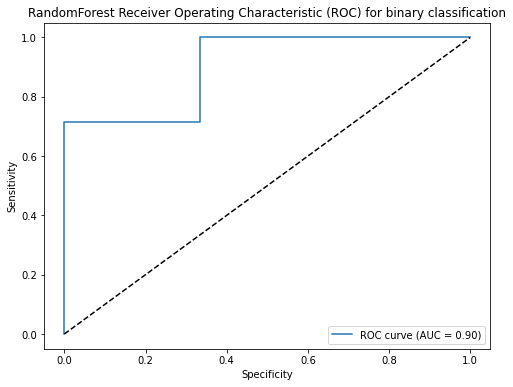

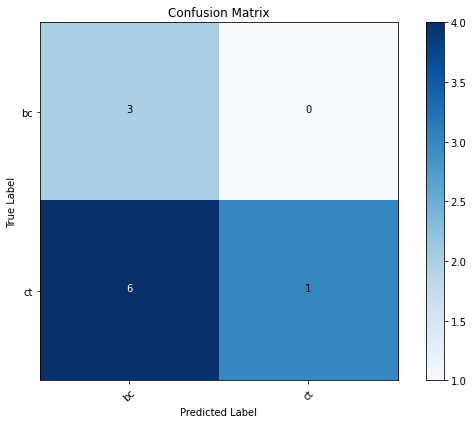

Classification Report:
              precision    recall  f1-score   support

          bc       0.33      1.00      0.50         3
          ct       1.00      0.14      0.25         7

    accuracy                           0.40        10
   macro avg       0.67      0.57      0.38        10
weighted avg       0.80      0.40      0.33        10



In [15]:
#Random Forest model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['binary_group'].values[1:]

# Convert class labels to binary matrix using LabelBinarizer
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_string).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

x = np.concatenate([flattened_image_features, num_features], axis=1)




# Number of runs for averaging results
num_runs = 10

# Initialize list to store AUC values for each class
auc_values = [[] for _ in range(len(set(y_string)))]

# Parameters for model training
#random_state = 42

# Loop for multiple runs
# for _ in range(num_runs):
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y_binary, test_size=0.2, random_state=42)

# Convert class labels to numerical labels
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)
# num_classes = len(label_encoder.classes_)

# Create a Naive Bayes classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict probabilities for each class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('RandomForest Receiver Operating Characteristic (ROC) for binary classification')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred = np.round(y_pred_prob)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


cm = confusion_matrix(y_test, y_pred)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))

Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.81
Class 3: ROC AUC = 0.57
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.81
Class 3: ROC AUC = 0.57
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.81
Class 3: ROC AUC = 0.57
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.81
Class 3: ROC AUC = 0.57
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.81
Class 3: ROC AUC = 0.57
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.81
Class 3: ROC AUC = 0.57
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.81
Class 3: ROC AUC = 0.57
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.81
Class 3: ROC AUC = 0.57
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.81
Class 3: ROC AUC = 0.57
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.81
Class 3: ROC AUC = 0.57


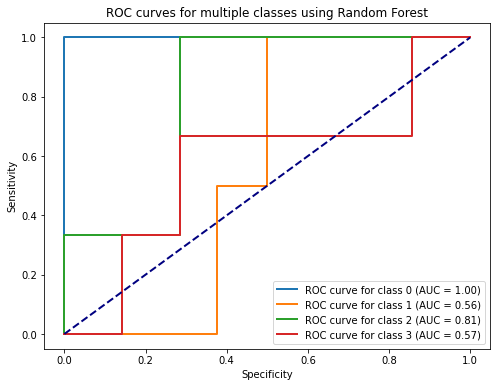

Classification Report for Class 0:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.50      0.67         2

    accuracy                           0.90        10
   macro avg       0.94      0.75      0.80        10
weighted avg       0.91      0.90      0.89        10

Classification Report for Class 1:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       0.00      0.00      0.00         2

    accuracy                           0.80        10
   macro avg       0.40      0.50      0.44        10
weighted avg       0.64      0.80      0.71        10

Classification Report for Class 2:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       0.00      0.00      0.00         3

    accuracy                           0.70        10
   macro avg       0.35

/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

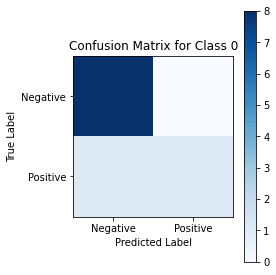

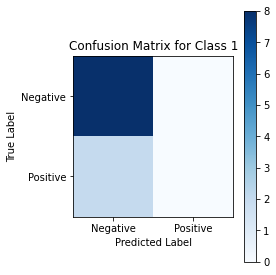

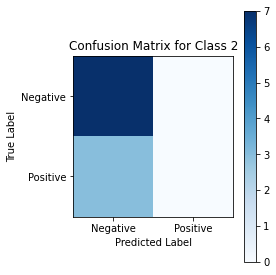

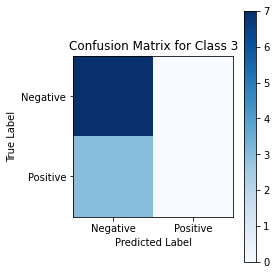

In [13]:
#Random Forest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['group'].values[1:]

# # Convert class labels to binary matrix using LabelBinarizer
# label_binarizer = LabelBinarizer()
# y_binary = label_binarizer.fit_transform(y_string).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

x = np.concatenate([flattened_image_features, num_features], axis=1)

# Number of runs for averaging results
num_runs = 10

# Initialize list to store AUC values for each class
auc_values = [[] for _ in range(len(set(y_string)))]

# Parameters for model training
random_state = 42

# Loop for multiple runs
for _ in range(num_runs):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(x, y_string, test_size=0.2, stratify=y_string, random_state=random_state)

    # Convert class labels to binary matrix using LabelBinarizer
    label_binarizer = LabelBinarizer()
    y_train_binary = label_binarizer.fit_transform(y_train)
    y_test_binary = label_binarizer.transform(y_test)
    #class_name = label_binarizer.classes_
    # Create a separate binary classifier for each class
    models = []
    all_pred_probs = []  # List to store predicted probabilities for each class

    for class_index in range(y_train_binary.shape[1]):
        # Create a Random Forest Classifier model
        model = RandomForestClassifier(n_estimators=100, random_state=random_state)

        # Train the model
        model.fit(X_train, y_train_binary[:, class_index])

        with open('RandomForest_model.pkl', 'wb') as model_file:
          pickle.dump(model, model_file)

        # Add the trained model to the list
        models.append(model)

        # Predict probabilities for the positive class
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Append predicted probabilities to the list
        all_pred_probs.append(y_pred_prob)

        # Calculate ROC curve and AUC for the positive class
        fpr, tpr, _ = roc_curve(y_test_binary[:, class_index], y_pred_prob)
        roc_auc = auc(fpr, tpr)
        auc_values[class_index].append((fpr, tpr))
        print(f"Class {class_index}: ROC AUC = {roc_auc:.2f}")

    # Convert list of predicted probabilities to a numpy array
    all_pred_probs = np.array(all_pred_probs)

# Calculate mean ROC curve for each class
mean_fpr_tpr = []
for class_index in range(len(auc_values)):
    fpr_values = [fpr for fpr, _ in auc_values[class_index]]
    tpr_values = [tpr for _, tpr in auc_values[class_index]]
    mean_fpr = np.mean(fpr_values, axis=0)
    mean_tpr = np.mean(tpr_values, axis=0)
    mean_fpr_tpr.append((mean_fpr, mean_tpr))

# Plot mean ROC curves for each class
plt.figure(figsize=(8, 6))
for class_index, (mean_fpr, mean_tpr) in enumerate(mean_fpr_tpr):
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, lw=2, label='ROC curve for class {} (AUC = {:.2f})'.format(class_index, mean_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curves for multiple classes using Random Forest')
plt.legend(loc="lower right")
plt.show()


# Initialize an empty array to store binary predictions for each class
all_pred_binary = []

# Threshold the predicted probabilities for each class separately
for class_index in range(y_train_binary.shape[1]):
    # Threshold the predicted probabilities to get the predicted labels for the current class
    y_pred_class_binary = (all_pred_probs[class_index] > 0.5).astype(int)
    all_pred_binary.append(y_pred_class_binary)

# Convert the list of binary predictions to a numpy array
all_pred_binary = np.array(all_pred_binary)

# Initialize empty lists to store metrics for each class
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []

# Calculate metrics for each class
for class_index in range(y_train_binary.shape[1]):
    # Generate classification report
    report = classification_report(y_test_binary[:, class_index], all_pred_binary[class_index])
    # Print classification report
    print(f"Classification Report for Class {class_index}:\n{report}")

    # Extract metrics from classification report
    report_dict = classification_report(y_test_binary[:, class_index], all_pred_binary[class_index], output_dict=True)
    # Append metrics to respective lists
    accuracy_list.append(report_dict['accuracy'])
    precision_list.append(report_dict['1']['precision'])
    recall_list.append(report_dict['1']['recall'])
    f1_score_list.append(report_dict['1']['f1-score'])

# Calculate average metrics across all classes
average_accuracy = np.mean(accuracy_list)
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

# Print average metrics
print(f"Average Accuracy: {average_accuracy}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1 Score: {average_f1_score}")


# Iterate over each class and plot confusion matrix
for class_index in range(y_test_binary.shape[1]):
    y_true_binary = y_test_binary[:, class_index]    # True labels for current class
    y_pred_binary = all_pred_binary[class_index]     # Predicted labels for current class

    # Compute confusion matrix
    cm = confusion_matrix(y_true_binary, y_pred_binary)

    # Plot confusion matrix
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Class {class_index}')
    plt.colorbar()
    
    # Manually specify tick labels for a 2x2 confusion matrix
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()



In [5]:
class_names

array(['Baseline', 'Cancer Treatment_03', 'Cancer Treatment_04',
       'Control'], dtype='<U19')

Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.38
Class 2: ROC AUC = 0.95
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.38
Class 2: ROC AUC = 0.95
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.38
Class 2: ROC AUC = 0.95
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.38
Class 2: ROC AUC = 0.95
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.38
Class 2: ROC AUC = 0.95
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.38
Class 2: ROC AUC = 0.95
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.38
Class 2: ROC AUC = 0.95
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.38
Class 2: ROC AUC = 0.95
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.38
Class 2: ROC AUC = 0.95
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 1.00
Class 1: ROC AUC = 0.38
Class 2: ROC AUC = 0.95
Class 3: ROC AUC = 0.86


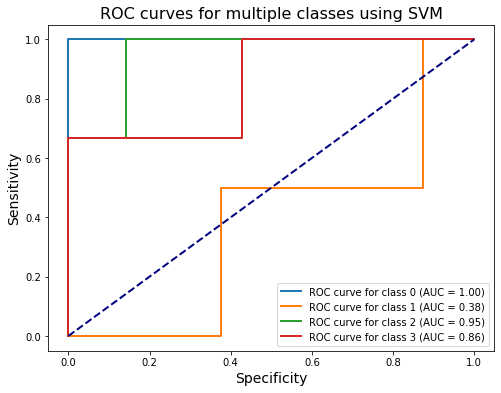

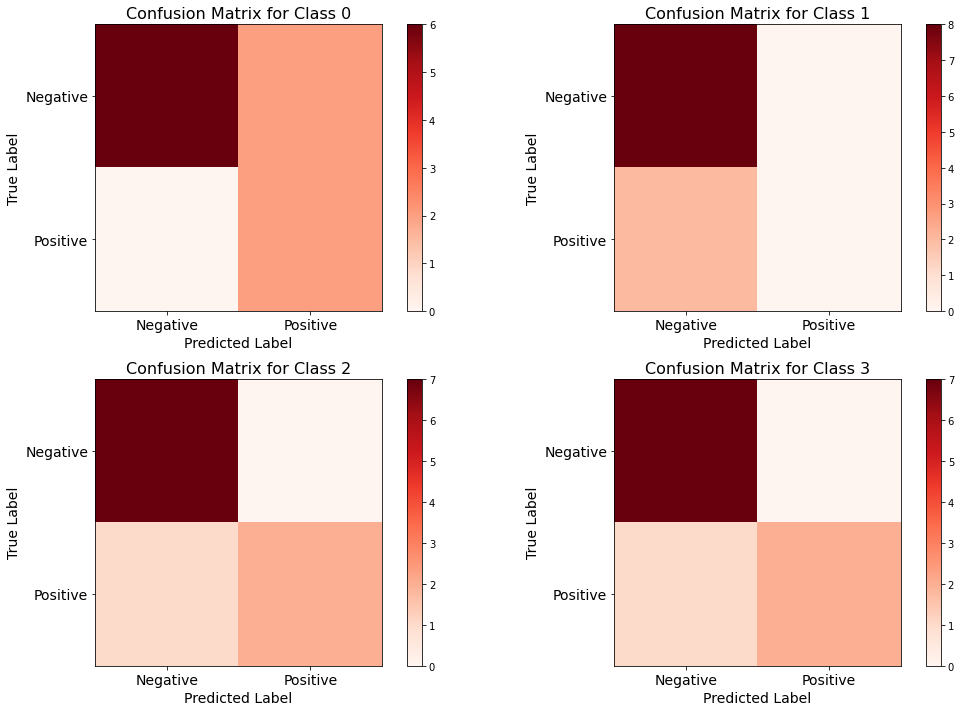

In [4]:
#SVC NEW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
import pickle

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['group'].values[1:]

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

X = np.concatenate([flattened_image_features, num_features], axis=1)



# Number of runs for averaging results
num_runs = 10

# Initialize list to store AUC values for each class
auc_values = [[] for _ in range(len(set(y_string)))]

# Parameters for model training
random_state = 42

# Loop for multiple runs
for _ in range(num_runs):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_string, test_size=0.2, stratify=y_string, random_state=random_state)

    # Convert class labels to binary matrix using LabelBinarizer
    label_binarizer = LabelBinarizer()
    y_train_binary = label_binarizer.fit_transform(y_train)
    y_test_binary = label_binarizer.transform(y_test)

    # Create a separate binary classifier for each class
    models = []
    all_pred_probs = []  # List to store predicted probabilities for each class
    for class_index in range(y_train_binary.shape[1]):
        # Create a Random Forest Classifier model
        model = SVC(probability=True, random_state=random_state)

        # Train the model
        model.fit(X_train, y_train_binary[:, class_index])

        with open('SVM_model.pkl', 'wb') as model_file:
          pickle.dump(model, model_file)

        # Add the trained model to the list
        models.append(model)

        # Predict probabilities for the positive class
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Append predicted probabilities to the list
        all_pred_probs.append(y_pred_prob)

        # Calculate ROC curve and AUC for the positive class
        fpr, tpr, _ = roc_curve(y_test_binary[:, class_index], y_pred_prob)
        roc_auc = auc(fpr, tpr)
        auc_values[class_index].append((fpr, tpr))
        print(f"Class {class_index}: ROC AUC = {roc_auc:.2f}")

    # Convert list of predicted probabilities to a numpy array
    all_pred_probs = np.array(all_pred_probs)

# Calculate mean ROC curve for each class
mean_fpr_tpr = []
for class_index in range(len(auc_values)):
    fpr_values = [fpr for fpr, _ in auc_values[class_index]]
    tpr_values = [tpr for _, tpr in auc_values[class_index]]
    mean_fpr = np.mean(fpr_values, axis=0)
    mean_tpr = np.mean(tpr_values, axis=0)
    mean_fpr_tpr.append((mean_fpr, mean_tpr))

# Plot mean ROC curves for each class
plt.figure(figsize=(8, 6))
for class_index, (mean_fpr, mean_tpr) in enumerate(mean_fpr_tpr):
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, lw=2, label='ROC curve for class {} (AUC = {:.2f})'.format(class_index, mean_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Specificity', fontsize = 14)
plt.ylabel('Sensitivity', fontsize = 14)
plt.title('ROC curves for multiple classes using SVM', fontsize = 16)
plt.legend(loc="lower right")
plt.show()


# Initialize an empty array to store binary predictions for each class
all_pred_binary = []

# Threshold the predicted probabilities for each class separately
for class_index in range(y_train_binary.shape[1]):
    # Threshold the predicted probabilities to get the predicted labels for the current class
    y_pred_class_binary = (all_pred_probs[class_index] > 0.5).astype(int)
    all_pred_binary.append(y_pred_class_binary)

# Convert the list of binary predictions to a numpy array
all_pred_binary = np.array(all_pred_binary)

# Initialize empty lists to store metrics for each class
# accuracy_list = []
# precision_list = []
# recall_list = []
# f1_score_list = []

# # Calculate metrics for each class
# for class_index in range(y_train_binary.shape[1]):
#     # Generate classification report
#     report = classification_report(y_test_binary[:, class_index], all_pred_binary[class_index])
#     # Print classification report
#     print(f"Classification Report for Class {class_index}:\n{report}")

#     # Extract metrics from classification report
#     report_dict = classification_report(y_test_binary[:, class_index], all_pred_binary[class_index], output_dict=True)
#     # Append metrics to respective lists
#     accuracy_list.append(report_dict['accuracy'])
#     precision_list.append(report_dict['1']['precision'])
#     recall_list.append(report_dict['1']['recall'])
#     f1_score_list.append(report_dict['1']['f1-score'])

# # Calculate average metrics across all classes
# average_accuracy = np.mean(accuracy_list)
# average_precision = np.mean(precision_list)
# average_recall = np.mean(recall_list)
# average_f1_score = np.mean(f1_score_list)

# # Print average metrics
# print(f"Average Accuracy: {average_accuracy}")
# print(f"Average Precision: {average_precision}")
# print(f"Average Recall: {average_recall}")
# print(f"Average F1 Score: {average_f1_score}")

# Iterate over each class and plot confusion matrix
# for class_index in range(y_test_binary.shape[1]):
#     y_true_binary = y_test_binary[:, class_index]    # True labels for current class
#     y_pred_binary = all_pred_binary[class_index]     # Predicted labels for current class

#     # Compute confusion matrix
#     cm = confusion_matrix(y_true_binary, y_pred_binary)

#     # Plot confusion matrix
#     plt.figure(figsize=(4, 4))
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title(f'Confusion Matrix for Class {class_index}')
#     plt.colorbar()
    
#     # Manually specify tick labels for a 2x2 confusion matrix
#     plt.xticks([0, 1], ['Negative', 'Positive'])
#     plt.yticks([0, 1], ['Negative', 'Positive'])
    
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.tight_layout()
#     plt.show()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for class_index in range(y_test_binary.shape[1]):
    row_index = class_index // 2
    col_index = class_index % 2

    y_true_binary = y_test_binary[:, class_index]    # True labels for current class
    y_pred_binary = all_pred_binary[class_index]     # Predicted labels for current class

    # Compute confusion matrix
    cm = confusion_matrix(y_true_binary, y_pred_binary)

    # Plot confusion matrix
    ax = axes[row_index, col_index]
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    ax.set_title(f'Confusion Matrix for Class {class_index}', fontsize = 16)
    plt.colorbar(im, ax=ax)
    
    # Manually specify tick labels for a 2x2 confusion matrix
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Negative', 'Positive'], fontsize = 14)
    ax.set_yticklabels(['Negative', 'Positive'], fontsize = 14)
    
    ax.set_xlabel('Predicted Label', fontsize = 14)
    ax.set_ylabel('True Label', fontsize = 14)

plt.tight_layout()
plt.show()


Class 0: ROC AUC = 0.94
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.71
Class 3: ROC AUC = 0.67
Class 0: ROC AUC = 0.94
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.71
Class 3: ROC AUC = 0.67
Class 0: ROC AUC = 0.94
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.71
Class 3: ROC AUC = 0.67
Class 0: ROC AUC = 0.94
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.71
Class 3: ROC AUC = 0.67
Class 0: ROC AUC = 0.94
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.71
Class 3: ROC AUC = 0.67
Class 0: ROC AUC = 0.94
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.71
Class 3: ROC AUC = 0.67
Class 0: ROC AUC = 0.94
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.71
Class 3: ROC AUC = 0.67
Class 0: ROC AUC = 0.94
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.71
Class 3: ROC AUC = 0.67
Class 0: ROC AUC = 0.94
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.71
Class 3: ROC AUC = 0.67
Class 0: ROC AUC = 0.94
Class 1: ROC AUC = 0.56
Class 2: ROC AUC = 0.71
Class 3: ROC AUC = 0.67


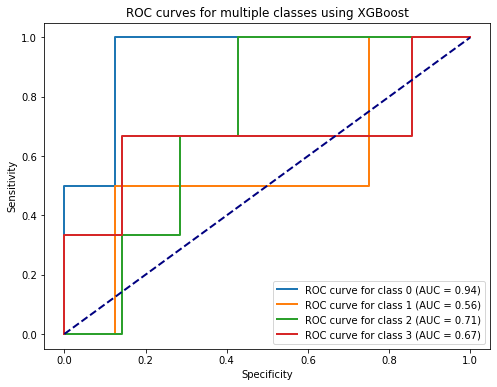

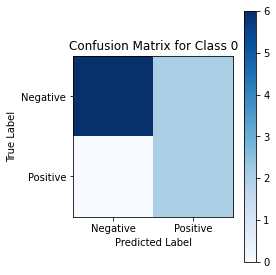

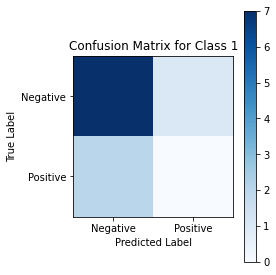

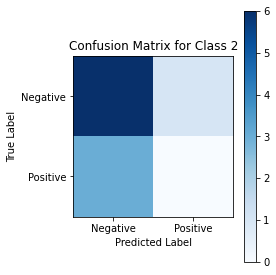

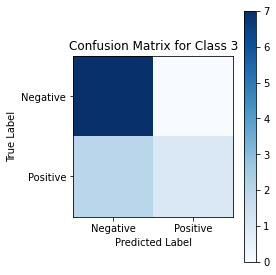

Classification Report for Class 0:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.50      1.00      0.67         2

    accuracy                           0.80        10
   macro avg       0.75      0.88      0.76        10
weighted avg       0.90      0.80      0.82        10

Classification Report for Class 1:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.00      0.00      0.00         2

    accuracy                           0.70        10
   macro avg       0.39      0.44      0.41        10
weighted avg       0.62      0.70      0.66        10

Classification Report for Class 2:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.00      0.00      0.00         3

    accuracy                           0.60        10
   macro avg       0.33

In [18]:
#XGBoost Model NEW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
import pickle

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['group'].values[1:]

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

X = np.concatenate([flattened_image_features, num_features], axis=1)



# Number of runs for averaging results
num_runs = 10

# Initialize list to store AUC values for each class
auc_values = [[] for _ in range(len(set(y_string)))]

# Parameters for model training
random_state = 42

# Loop for multiple runs
for _ in range(num_runs):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_string, test_size=0.2, stratify=y_string, random_state=random_state)

    # Convert class labels to binary matrix using LabelBinarizer
    label_binarizer = LabelBinarizer()
    y_train_binary = label_binarizer.fit_transform(y_train)
    y_test_binary = label_binarizer.transform(y_test)

    # Create a separate binary classifier for each class
    models = []
    all_pred_probs = []  # List to store predicted probabilities for each class
    for class_index in range(y_train_binary.shape[1]):
        # Create a Random Forest Classifier model
        model = XGBClassifier(use_label_encoder=False, eval_metric='error', objective='binary:logistic', random_state=random_state)

        # Train the model
        model.fit(X_train, y_train_binary[:, class_index])


        # Add the trained model to the list
        models.append(model)

        # Predict probabilities for the positive class
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Append predicted probabilities to the list
        all_pred_probs.append(y_pred_prob)

        # Calculate ROC curve and AUC for the positive class
        fpr, tpr, _ = roc_curve(y_test_binary[:, class_index], y_pred_prob)
        roc_auc = auc(fpr, tpr)
        auc_values[class_index].append((fpr, tpr))
        print(f"Class {class_index}: ROC AUC = {roc_auc:.2f}")

    # Convert list of predicted probabilities to a numpy array
    all_pred_probs = np.array(all_pred_probs)

with open('XGB_model.pkl', 'wb') as model_file:
          pickle.dump(model, model_file)

# Calculate mean ROC curve for each class
mean_fpr_tpr = []
for class_index in range(len(auc_values)):
    fpr_values = [fpr for fpr, _ in auc_values[class_index]]
    tpr_values = [tpr for _, tpr in auc_values[class_index]]
    mean_fpr = np.mean(fpr_values, axis=0)
    mean_tpr = np.mean(tpr_values, axis=0)
    mean_fpr_tpr.append((mean_fpr, mean_tpr))


# Plot mean ROC curves for each class
plt.figure(figsize=(8, 6))
for class_index, (mean_fpr, mean_tpr) in enumerate(mean_fpr_tpr):
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, lw=2, label='ROC curve for class {} (AUC = {:.2f})'.format(class_index, mean_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curves for multiple classes using XGBoost')
plt.legend(loc="lower right")
plt.show()


# Initialize an empty array to store binary predictions for each class
all_pred_binary = []

# Threshold the predicted probabilities for each class separately
for class_index in range(y_train_binary.shape[1]):
    # Threshold the predicted probabilities to get the predicted labels for the current class
    y_pred_class_binary = (all_pred_probs[class_index] > 0.5).astype(int)
    all_pred_binary.append(y_pred_class_binary)

# Convert the list of binary predictions to a numpy array
all_pred_binary = np.array(all_pred_binary)



# Iterate over each class and plot confusion matrix
for class_index in range(y_test_binary.shape[1]):
    y_true_binary = y_test_binary[:, class_index]    # True labels for current class
    y_pred_binary = all_pred_binary[class_index]     # Predicted labels for current class

    # Compute confusion matrix
    cm = confusion_matrix(y_true_binary, y_pred_binary)

    # Plot confusion matrix
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Class {class_index}')
    plt.colorbar()
    
    # Manually specify tick labels for a 2x2 confusion matrix
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Initialize empty lists to store metrics for each class
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []

# Calculate metrics for each class
for class_index in range(y_train_binary.shape[1]):
    # Generate classification report
    report = classification_report(y_test_binary[:, class_index], all_pred_binary[class_index])
    # Print classification report
    print(f"Classification Report for Class {class_index}:\n{report}")

    # Extract metrics from classification report
    report_dict = classification_report(y_test_binary[:, class_index], all_pred_binary[class_index], output_dict=True)
    # Append metrics to respective lists
    accuracy_list.append(report_dict['accuracy'])
    precision_list.append(report_dict['1']['precision'])
    recall_list.append(report_dict['1']['recall'])
    f1_score_list.append(report_dict['1']['f1-score'])

# Calculate average metrics across all classes
average_accuracy = np.mean(accuracy_list)
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

# Print average metrics
print(f"Average Accuracy: {average_accuracy}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1 Score: {average_f1_score}")

Class 0: ROC AUC = 0.83
Class 1: ROC AUC = 0.62
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.78
Class 0: ROC AUC = 0.83
Class 1: ROC AUC = 0.62
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.78
Class 0: ROC AUC = 0.83
Class 1: ROC AUC = 0.62
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.78
Class 0: ROC AUC = 0.83
Class 1: ROC AUC = 0.62
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.78
Class 0: ROC AUC = 0.83
Class 1: ROC AUC = 0.62
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.78
Class 0: ROC AUC = 0.83
Class 1: ROC AUC = 0.62
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.78
Class 0: ROC AUC = 0.83
Class 1: ROC AUC = 0.62
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.78
Class 0: ROC AUC = 0.83
Class 1: ROC AUC = 0.62
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.78
Class 0: ROC AUC = 0.83
Class 1: ROC AUC = 0.62
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.78
Class 0: ROC AUC = 0.83
Class 1: ROC AUC = 0.62
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.78


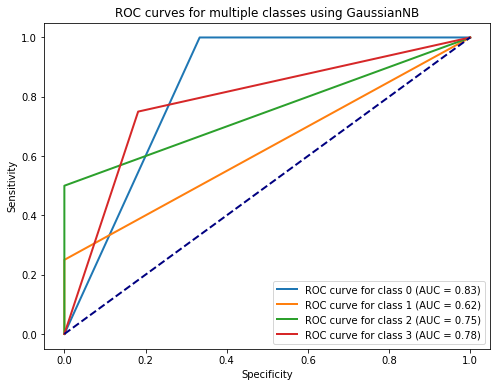

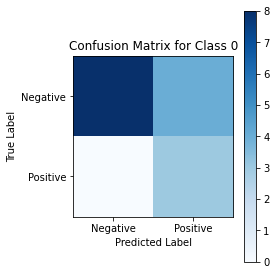

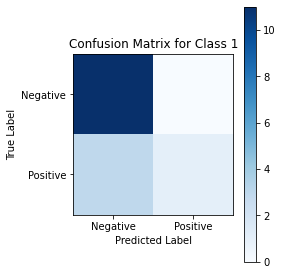

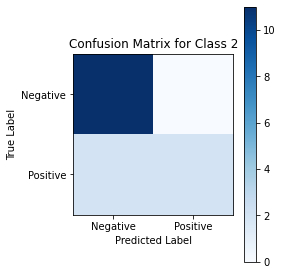

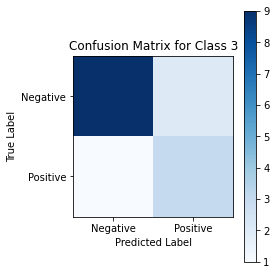

Classification Report for Class 0:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       1.00      0.25      0.40         4
           2       1.00      0.50      0.67         4
           3       0.60      0.75      0.67         4

    accuracy                           0.60        15
   macro avg       0.76      0.62      0.58        15
weighted avg       0.78      0.60      0.58        15

Classification Report for Class 1:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       1.00      0.25      0.40         4
           2       1.00      0.50      0.67         4
           3       0.60      0.75      0.67         4

    accuracy                           0.60        15
   macro avg       0.76      0.62      0.58        15
weighted avg       0.78      0.60      0.58        15

Classification Report for Class 2:
              precision  

In [5]:
#GaussianNB model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['group'].values[1:]

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

X = np.concatenate([flattened_image_features, num_features], axis=1)

# Number of runs for averaging results
num_runs = 10

# Initialize list to store AUC values for each class
auc_values = [[] for _ in range(len(set(y_string)))]

# Parameters for model training
random_state = 42

# Loop for multiple runs
for _ in range(num_runs):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_string, test_size=0.3, stratify=y_string, random_state=random_state)

    # label_binarizer = LabelBinarizer()
    # y_train_binary = label_binarizer.fit_transform(y_train)
    # y_test_binary = label_binarizer.transform(y_test)

    # Convert class labels to numerical labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    num_classes = len(label_encoder.classes_)

    # Create a Naive Bayes classifier
    model = GaussianNB()

    # Train the model
    model.fit(X_train, y_train_encoded)

    # Predict probabilities for each class
    y_pred_prob = model.predict_proba(X_test)

    # Calculate ROC curve and AUC for each class
    for class_index in range(num_classes):
        y_true_binary_class = (y_test_encoded == class_index).astype(int)
        y_pred_prob_class = y_pred_prob[:, class_index]
        fpr, tpr, _ = roc_curve(y_true_binary_class, y_pred_prob_class)
        roc_auc = auc(fpr, tpr)
        auc_values[class_index].append((fpr, tpr))
        print(f"Class {class_index}: ROC AUC = {roc_auc:.2f}")

# Calculate mean ROC curve for each class
mean_fpr_tpr = []
for class_index in range(num_classes):
    fpr_values = []
    tpr_values = []
    for fpr, tpr in auc_values[class_index]:
        fpr_values.append(fpr)
        tpr_values.append(tpr)
    mean_fpr = np.mean(fpr_values, axis=0)
    mean_tpr = np.mean(tpr_values, axis=0)
    mean_fpr_tpr.append((mean_fpr, mean_tpr))


# Plot mean ROC curves for each class
plt.figure(figsize=(8, 6))
for class_index, (mean_fpr, mean_tpr) in enumerate(mean_fpr_tpr):
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot([0] + list(mean_fpr), [0] + list(mean_tpr), lw=2, label='ROC curve for class {} (AUC = {:.2f})'.format(class_index, mean_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curves for multiple classes using GaussianNB')
plt.legend(loc="lower right")
plt.show()

# Initialize an empty array to store binary predictions for each class
all_pred_binary = []

# Threshold the predicted probabilities for each class separately
for class_index in range(num_classes):
    # Threshold the predicted probabilities to get the predicted labels for the current class
    y_pred_class_binary = np.argmax(y_pred_prob, axis=1)
    all_pred_binary.append(y_pred_class_binary)


# Convert the list of binary predictions to a numpy array
all_pred_binary = np.array(all_pred_binary)


# Iterate over each class and plot confusion matrix
for class_index in range(num_classes):
    # Filter true and predicted labels for the current class
    y_true_class = (y_test_encoded == class_index).astype(int)
    y_pred_class = (all_pred_binary[class_index] == class_index).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_class, y_pred_class)

    # Plot confusion matrix
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Class {class_index}')
    plt.colorbar()

    # Manually specify tick labels for a 2x2 confusion matrix
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Initialize empty lists to store metrics for each class
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []

# Calculate metrics for each class
for class_index in range(num_classes):
    # Generate classification report
    report = classification_report(y_test_encoded, all_pred_binary[class_index])
    # Print classification report
    print(f"Classification Report for Class {class_index}:\n{report}")

    # Extract metrics from classification report
    report_dict = classification_report(y_test_encoded, all_pred_binary[class_index], output_dict=True)
    # Append metrics to respective lists
    accuracy_list.append(report_dict['accuracy'])
    precision_list.append(report_dict['1']['precision'])
    recall_list.append(report_dict['1']['recall'])
    f1_score_list.append(report_dict['1']['f1-score'])
    
# Calculate average metrics across all classes
average_accuracy = np.mean(accuracy_list)
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

# Print average metrics
print(f"Average Accuracy: {average_accuracy}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1 Score: {average_f1_score}")

Using Theano backend.
/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ami

Class 0: ROC AUC = 0.89


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.43


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.93


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.84


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.83


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.43


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.89


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.77


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.92


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.50


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.86


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.82


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.83


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.59


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.93


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.86


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.89


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.55


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.91


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.91


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.86


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.48


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.98


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.86


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.86


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.55


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.89


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.89


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.89


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.55


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.98


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.89


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.92


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.41


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.93


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.80


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.81


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.41


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.93


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.84


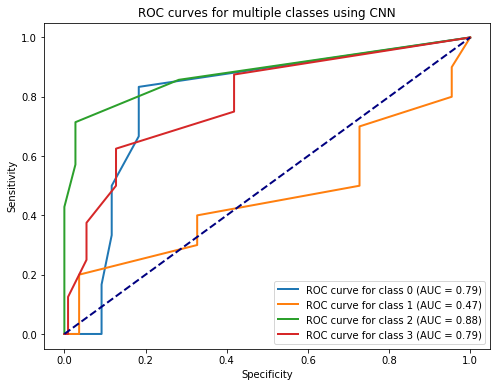

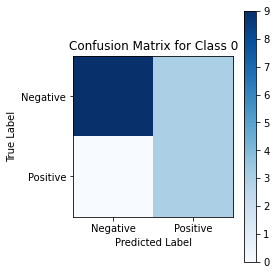

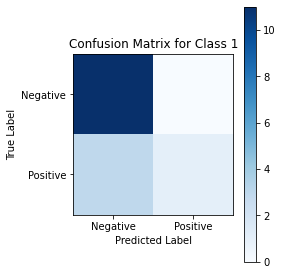

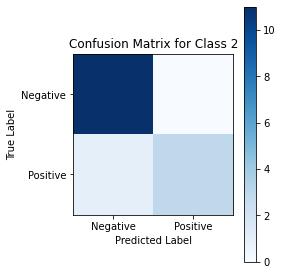

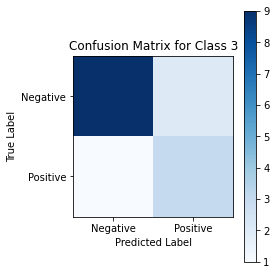

Classification Report for Class 0:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       1.00      0.25      0.40         4
           2       1.00      0.75      0.86         4
           3       0.60      0.75      0.67         4

    accuracy                           0.67        15
   macro avg       0.78      0.69      0.65        15
weighted avg       0.79      0.67      0.65        15

Classification Report for Class 1:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       1.00      0.25      0.40         4
           2       1.00      0.75      0.86         4
           3       0.60      0.75      0.67         4

    accuracy                           0.67        15
   macro avg       0.78      0.69      0.65        15
weighted avg       0.79      0.67      0.65        15

Classification Report for Class 2:
              precision  

In [1]:
#CNN model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report


# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['group'].values[1:]

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)
X = np.concatenate([flattened_image_features, num_features], axis=1)

# num_flattened_image_features = np.prod(image_features.shape[1:])  # Product of dimensions excluding samples
# print("Number of flattened image features:", num_flattened_image_features)
# X = np.concatenate([image_features.reshape(image_features.shape[0], -1), num_features], axis=1)



# Number of runs for averaging results
num_runs = 10

# Initialize list to store AUC values for each class
auc_values = [[] for _ in range(len(set(y_string)))]

# Parameters for model training
random_state = 42

# Reshape X for CNN input (assuming you want to treat each feature as a channel)
#X = X.reshape(X.shape[0], 1, 5, 1)

# Loop for multiple runs
for _ in range(num_runs):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_string, test_size=0.3, stratify=y_string, random_state=random_state)

    # Convert class labels to numerical labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    num_classes = len(label_encoder.classes_)

    # Create a CNN model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(25093,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))  # Use softmax activation for multi-class classification

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Use sparse categorical crossentropy for multi-class classification

    # # Train the model
    # model.fit(X_train, y_train_encoded, batch_size=32, epochs=10, verbose=0)

    # model.save('CNN_model.h5')

    # # Predict probabilities for each class
    # y_pred_prob = model.predict(X_test)
    #all_pred_probs = []
    # Calculate ROC curve and AUC for each class
    for class_index in range(num_classes):
        # Train the model
        model.fit(X_train, y_train_encoded, batch_size=32, epochs=10, verbose=0)

        model.save('CNN_model.h5')

        # Predict probabilities for each class
        y_pred_prob = model.predict(X_test)
        #all_pred_probs.append(y_pred_prob)

        y_true_binary_class = (y_test_encoded == class_index).astype(int)
        y_pred_prob_class = y_pred_prob[:, class_index]
        fpr, tpr, _ = roc_curve(y_true_binary_class, y_pred_prob_class)
        roc_auc = auc(fpr, tpr)
        auc_values[class_index].append((fpr, tpr))
        print(f"Class {class_index}: ROC AUC = {roc_auc:.2f}")
        
    # # Convert list of predicted probabilities to a numpy array
    # all_pred_probs = np.array(all_pred_probs)

# Calculate mean ROC curve for each class
# mean_fpr_tpr = []
# for class_index in range(num_classes):
#     fpr_values = []
#     tpr_values = []
#     for fpr, tpr in auc_values[class_index]:
#         interp_tpr = np.interp(mean_fpr, fpr, tpr)
#         fpr_values.append(mean_fpr)
#         tpr_values.append(interp_tpr)
#     mean_tpr = np.mean(tpr_values, axis=0)
#     mean_auc = auc(mean_fpr, mean_tpr)
#     mean_fpr_tpr.append((mean_fpr, mean_tpr))

# # Calculate mean ROC curve for each class
# mean_fpr_tpr = []
# for class_index in range(num_classes):
#     fpr_values = []
#     tpr_values = []
#     for fpr, tpr in auc_values[class_index]:
#         fpr_values.append(fpr)
#         tpr_values.append(tpr)
#     mean_fpr = np.mean(fpr_values, axis=0)
#     mean_tpr = np.mean(tpr_values, axis=0)
#     mean_fpr_tpr.append((mean_fpr, mean_tpr))

# Calculate mean ROC curve for each class
mean_fpr_tpr = []
for class_index in range(num_classes):
    fpr_values = []
    tpr_values = []
    max_len = 0  # Track the maximum length of FPR and TPR values among all runs
    for fpr, tpr in auc_values[class_index]:
        fpr_values.append(fpr)
        tpr_values.append(tpr)
        max_len = max(max_len, len(fpr), len(tpr))
    
    # Interpolate FPR and TPR values for each run to ensure they have the same length
    interp_fpr_values = [np.interp(np.linspace(0, 1, max_len), tpr, fpr) for fpr, tpr in zip(fpr_values, tpr_values)]
    interp_tpr_values = [np.interp(np.linspace(0, 1, max_len), tpr, tpr) for tpr in tpr_values]
    
    # Calculate mean FPR and TPR
    mean_fpr = np.mean(interp_fpr_values, axis=0)
    mean_tpr = np.mean(interp_tpr_values, axis=0)
    
    mean_fpr_tpr.append((mean_fpr, mean_tpr))



# Plot mean ROC curves for each class
plt.figure(figsize=(8, 6))
for class_index, (mean_fpr, mean_tpr) in enumerate(mean_fpr_tpr):
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot([0] + list(mean_fpr), [0] + list(mean_tpr), lw=2, label='ROC curve for class {} (AUC = {:.2f})'.format(class_index, mean_auc))


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curves for multiple classes using CNN')
plt.legend(loc="lower right")
plt.show()

# Initialize an empty array to store binary predictions for each class
all_pred_binary = []

# Threshold the predicted probabilities for each class separately
for class_index in range(num_classes):
    # Threshold the predicted probabilities to get the predicted labels for the current class
    y_pred_class_binary = np.argmax(y_pred_prob, axis=1)
    all_pred_binary.append(y_pred_class_binary)
    # y_pred_class_binary = (all_pred_probs[class_index] > 0.5).astype(int)
    # all_pred_binary.append(y_pred_class_binary)


# Convert the list of binary predictions to a numpy array
all_pred_binary = np.array(all_pred_binary)


# Iterate over each class and plot confusion matrix
for class_index in range(num_classes):
    # Filter true and predicted labels for the current class
    y_true_class = (y_test_encoded == class_index).astype(int)
    y_pred_class = (all_pred_binary[class_index] == class_index).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_class, y_pred_class)

    # Plot confusion matrix
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Class {class_index}')
    plt.colorbar()

    # Manually specify tick labels for a 2x2 confusion matrix
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []

# Calculate metrics for each class
for class_index in range(num_classes):
    # Generate classification report
    report = classification_report(y_test_encoded, all_pred_binary[class_index])
    # Print classification report
    print(f"Classification Report for Class {class_index}:\n{report}")

    # Extract metrics from classification report
    report_dict = classification_report(y_test_encoded, all_pred_binary[class_index], output_dict=True)
    # Append metrics to respective lists
    accuracy_list.append(report_dict['accuracy'])
    precision_list.append(report_dict['1']['precision'])
    recall_list.append(report_dict['1']['recall'])
    f1_score_list.append(report_dict['1']['f1-score'])
    
# Calculate average metrics across all classes
average_accuracy = np.mean(accuracy_list)
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

# Print average metrics
print(f"Average Accuracy: {average_accuracy}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1 Score: {average_f1_score}")

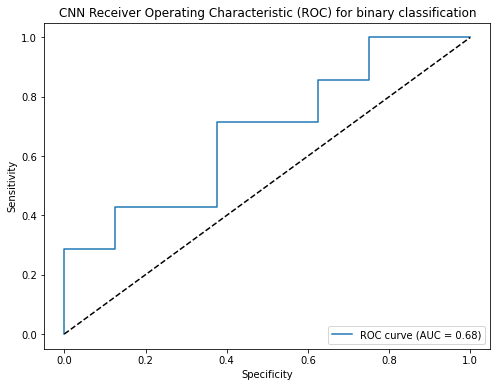

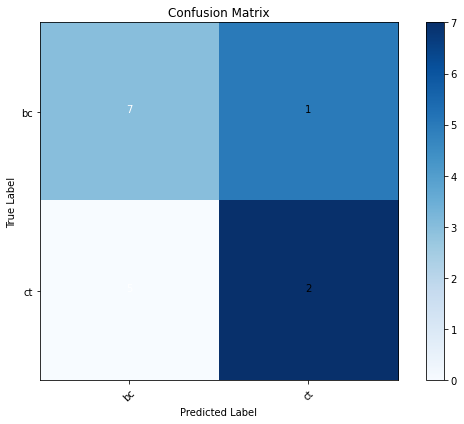

Classification Report:
              precision    recall  f1-score   support

          bc       0.58      0.88      0.70         8
          ct       0.67      0.29      0.40         7

    accuracy                           0.60        15
   macro avg       0.62      0.58      0.55        15
weighted avg       0.62      0.60      0.56        15



In [35]:
#CNN for binary classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelBinarizer

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_binary = df['binary_group'].values[1:]

label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_binary).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)
X = np.concatenate([flattened_image_features, num_features], axis=1)

# Number of runs for averaging results
#num_runs = 10

# Initialize list to store AUC values for binary classification
auc_values = []

# Parameters for model training
random_state = 42

# Loop for multiple runs
#for _ in range(num_runs):
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, stratify=y_binary, random_state=random_state)


# Create a binary classification model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(25093,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid activation for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)

# Predict probabilities for positive class
y_pred_prob = model.predict(X_test)

# Calculate ROC curve and AUC for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
#auc_values.append((fpr, tpr))
#print(f"ROC AUC = {roc_auc:.2f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('CNN Receiver Operating Characteristic (ROC) for binary classification')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred = np.round(y_pred_prob)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


cm = confusion_matrix(y_test, y_pred)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))


In [2]:
#LSTM Model for binary classification

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelBinarizer

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_binary = df['binary_group'].values[1:]

# Convert class labels to binary matrix using LabelBinarizer
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_binary).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

# Preprocess image data
images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)
X = np.concatenate([flattened_image_features, num_features], axis=1)

# Initialize list to store AUC values for binary classification
auc_values = []

# Parameters for model training
random_state = 42

# Reshape X for LSTM input
X = X.reshape(X.shape[0], 1, X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, stratify=y_binary, random_state=random_state)

# Create an LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, 25093), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid activation for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)

# Predict probabilities for positive class
y_pred_prob = model.predict(X_test)

# Calculate ROC curve and AUC for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('RandomForest Receiver Operating Characteristic (ROC) for binary classification')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred = np.round(y_pred_prob)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


cm = confusion_matrix(y_test, y_pred)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))

/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/amit/anaconda3/envs/multi

ValueError: Found input variables with inconsistent numbers of samples: [49, 196]

/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.88


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.31


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.62


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.62


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.75


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.38


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.86


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.57


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.88


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.50


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.67


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.57


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 1.00


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.19


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.52


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.62


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.81


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.31


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.95


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.57


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.81


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.50


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.90


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.52


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.94


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.25


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.71


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.90


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.88


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.44


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.90


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.57


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.88


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.44


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 1.00


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.57


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 0: ROC AUC = 0.88


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 1: ROC AUC = 0.38


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 2: ROC AUC = 0.95


/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/theano/tensor/subtensor.py:2286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Class 3: ROC AUC = 0.71


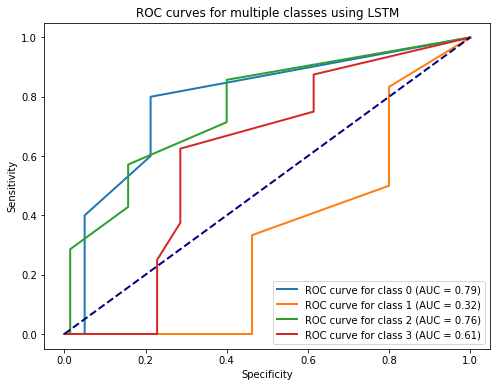

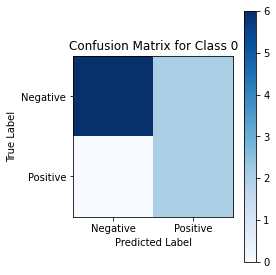

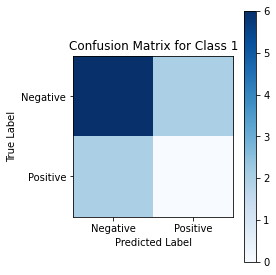

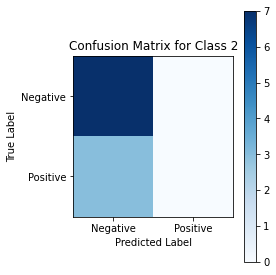

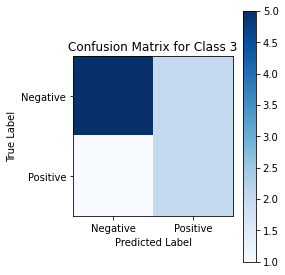

Classification Report for Class 0:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3
           3       0.50      0.67      0.57         3

    accuracy                           0.40        10
   macro avg       0.25      0.42      0.31        10
weighted avg       0.25      0.40      0.30        10

Classification Report for Class 1:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3
           3       0.50      0.67      0.57         3

    accuracy                           0.40        10
   macro avg       0.25      0.42      0.31        10
weighted avg       0.25      0.40      0.30        10

Classification Report for Class 2:
              precision  

/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amit/anaconda3/envs/multimodality/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [3]:
#LSTM Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report


# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['group'].values[1:]

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)
X = np.concatenate([flattened_image_features, num_features], axis=1)

# Number of runs for averaging results
num_runs = 10

# Initialize list to store AUC values for each class
auc_values = [[] for _ in range(len(set(y_string)))]

# Parameters for model training
random_state = 42

# Reshape X for LSTM input
X = X.reshape(X.shape[0], 1, X.shape[1])

# Loop for multiple runs
for _ in range(num_runs):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_string, test_size=0.2, stratify=y_string, random_state=random_state)

    # Convert class labels to numerical labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    num_classes = len(label_encoder.classes_)

    # Create an LSTM model
    model = Sequential()
    model.add(LSTM(64, input_shape=(1, 25093), return_sequences=True))
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(16))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # # Train the model
    # model.fit(X_train, y_train_encoded, batch_size=32, epochs=10, verbose=0)

    # model.save('LSTM_model.h5')

    # # Predict probabilities for each class
    # y_pred_prob = model.predict(X_test)

    # Calculate ROC curve and AUC for each class
    for class_index in range(num_classes):
        # Train the model
        model.fit(X_train, y_train_encoded, batch_size=32, epochs=10, verbose=0)

        model.save('LSTM_model.h5')

        # Predict probabilities for each class
        y_pred_prob = model.predict(X_test)



        y_true_binary_class = (y_test_encoded == class_index).astype(int)
        y_pred_prob_class = y_pred_prob[:, class_index]
        fpr, tpr, _ = roc_curve(y_true_binary_class, y_pred_prob_class)
        roc_auc = auc(fpr, tpr)
        auc_values[class_index].append((fpr, tpr))
        print(f"Class {class_index}: ROC AUC = {roc_auc:.2f}")

# Calculate mean ROC curve for each class
# mean_fpr_tpr = []
# for class_index in range(num_classes):
#     fpr_values = []
#     tpr_values = []
#     for fpr, tpr in auc_values[class_index]:
#         interp_tpr = np.interp(mean_fpr, fpr, tpr)
#         fpr_values.append(mean_fpr)
#         tpr_values.append(interp_tpr)
#     mean_tpr = np.mean(tpr_values, axis=0)
#     mean_auc = auc(mean_fpr, mean_tpr)
#     mean_fpr_tpr.append((mean_fpr, mean_tpr))

mean_fpr_tpr = []
for class_index in range(num_classes):
    fpr_values = []
    tpr_values = []
    max_len = 0  # Track the maximum length of FPR and TPR values among all runs
    for fpr, tpr in auc_values[class_index]:
        fpr_values.append(fpr)
        tpr_values.append(tpr)
        max_len = max(max_len, len(fpr), len(tpr))
    
    # Interpolate FPR and TPR values for each run to ensure they have the same length
    interp_fpr_values = [np.interp(np.linspace(0, 1, max_len), tpr, fpr) for fpr, tpr in zip(fpr_values, tpr_values)]
    interp_tpr_values = [np.interp(np.linspace(0, 1, max_len), tpr, tpr) for tpr in tpr_values]
    
    # Calculate mean FPR and TPR
    mean_fpr = np.mean(interp_fpr_values, axis=0)
    mean_tpr = np.mean(interp_tpr_values, axis=0)
    
    mean_fpr_tpr.append((mean_fpr, mean_tpr))


# Plot mean ROC curves for each class
plt.figure(figsize=(8, 6))
for class_index, (mean_fpr, mean_tpr) in enumerate(mean_fpr_tpr):
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot([0] + list(mean_fpr), [0] + list(mean_tpr), lw=2, label='ROC curve for class {} (AUC = {:.2f})'.format(class_index, mean_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curves for multiple classes using LSTM')
plt.legend(loc="lower right")
plt.show()

# Initialize an empty array to store binary predictions for each class
all_pred_binary = []

# Threshold the predicted probabilities for each class separately
for class_index in range(num_classes):
    # Threshold the predicted probabilities to get the predicted labels for the current class
    y_pred_class_binary = np.argmax(y_pred_prob, axis=1)
    all_pred_binary.append(y_pred_class_binary)


# Convert the list of binary predictions to a numpy array
all_pred_binary = np.array(all_pred_binary)



# Iterate over each class and plot confusion matrix
for class_index in range(num_classes):
    # Filter true and predicted labels for the current class
    y_true_class = (y_test_encoded == class_index).astype(int)
    y_pred_class = (all_pred_binary[class_index] == class_index).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_class, y_pred_class)

    # Plot confusion matrix
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Class {class_index}')
    plt.colorbar()

    # Manually specify tick labels for a 2x2 confusion matrix
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []

# Calculate metrics for each class
for class_index in range(num_classes):
    # Generate classification report
    report = classification_report(y_test_encoded, all_pred_binary[class_index])
    # Print classification report
    print(f"Classification Report for Class {class_index}:\n{report}")

    # Extract metrics from classification report
    report_dict = classification_report(y_test_encoded, all_pred_binary[class_index], output_dict=True)
    # Append metrics to respective lists
    accuracy_list.append(report_dict['accuracy'])
    precision_list.append(report_dict['1']['precision'])
    recall_list.append(report_dict['1']['recall'])
    f1_score_list.append(report_dict['1']['f1-score'])
    
for class_index in range(num_classes):
    # Generate classification report with zero_division='warn'
    report = classification_report(y_test_encoded, all_pred_binary[class_index], zero_division= 1)
    # Print classification report
    print(f"Classification Report for Class {class_index}:\n{report}")

    # Extract metrics from classification report
    report_dict = classification_report(y_test_encoded, all_pred_binary[class_index], output_dict=True, zero_division= 1)
    # Append metrics to respective lists
    accuracy_list.append(report_dict['accuracy'])
    precision_list.append(report_dict['1']['precision'])
    recall_list.append(report_dict['1']['recall'])
    f1_score_list.append(report_dict['1']['f1-score'])
# Calculate average metrics across all classes
average_accuracy = np.mean(accuracy_list)
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

# Print average metrics
print(f"Average Accuracy: {average_accuracy}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1 Score: {average_f1_score}")

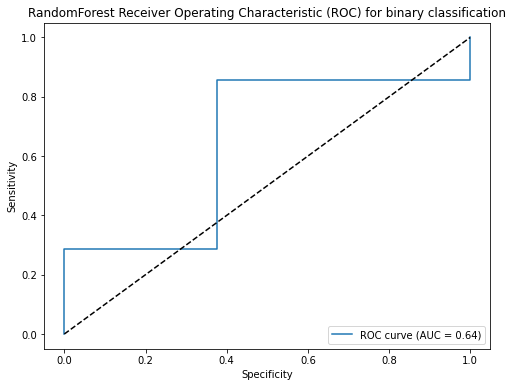

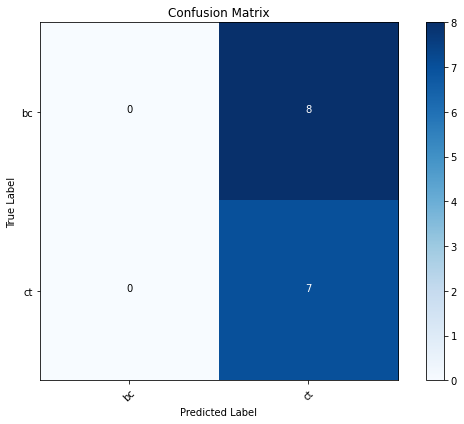

Classification Report:
              precision    recall  f1-score   support

          bc       0.00      0.00      0.00         8
          ct       0.47      1.00      0.64         7

    accuracy                           0.47        15
   macro avg       0.23      0.50      0.32        15
weighted avg       0.22      0.47      0.30        15



In [64]:
#AutoEncoder Decoder for binary classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_binary = df['binary_group'].values[1:]

# Convert class labels to binary matrix using LabelBinarizer
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(y_binary).flatten()

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)

X = np.concatenate([flattened_image_features, num_features], axis=1)

auc_values = []

# Parameters for model training
random_state = 42

# Reshape X for autoencoder input
X = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, stratify=y_binary, random_state=random_state)

# Create an autoencoder-decoder model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)

# Encode and decode the test data

y_pred_prob = model.predict(X_test)

# Calculate reconstruction error
#reconstruction_error = np.mean(np.square(X_test - encoded_X_test), axis=1)

# Calculate ROC curve and AUC for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('RandomForest Receiver Operating Characteristic (ROC) for binary classification')
plt.legend(loc="lower right")
plt.show()

# Get predicted labels
y_pred = np.round(y_pred_prob)
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_binarizer.classes_))
plt.xticks(tick_marks, label_binarizer.classes_, rotation=45)
plt.yticks(tick_marks, label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')




# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))

In [60]:
y_pred_prob

array([[2.7843975e-04, 5.3877644e-05, 4.9372287e-05, ..., 9.9999523e-01,
        5.4985082e-01, 3.0827119e-05],
       [5.7904219e-04, 1.3178375e-04, 1.2057707e-04, ..., 9.9998558e-01,
        5.4660147e-01, 7.9009253e-05],
       [4.0225778e-04, 8.4931307e-05, 7.7621633e-05, ..., 9.9999166e-01,
        5.4829055e-01, 4.9626622e-05],
       ...,
       [2.6773565e-04, 5.1839925e-05, 4.7257217e-05, ..., 9.9999547e-01,
        5.5017292e-01, 2.9444980e-05],
       [3.5740327e-04, 7.2584720e-05, 6.6837005e-05, ..., 9.9999309e-01,
        5.4774213e-01, 4.2207586e-05],
       [2.2322516e-04, 4.2124349e-05, 3.8343976e-05, ..., 9.9999654e-01,
        5.5117846e-01, 2.3600756e-05]], dtype=float32)

Class 0: ROC AUC = 0.81
Class 1: ROC AUC = 0.48
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 0.81
Class 1: ROC AUC = 0.48
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 0.81
Class 1: ROC AUC = 0.48
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 0.81
Class 1: ROC AUC = 0.48
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 0.81
Class 1: ROC AUC = 0.48
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 0.81
Class 1: ROC AUC = 0.48
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 0.81
Class 1: ROC AUC = 0.48
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 0.81
Class 1: ROC AUC = 0.48
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 0.81
Class 1: ROC AUC = 0.48
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.86
Class 0: ROC AUC = 0.81
Class 1: ROC AUC = 0.48
Class 2: ROC AUC = 0.75
Class 3: ROC AUC = 0.86


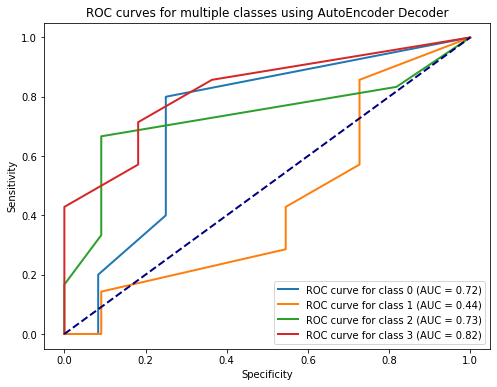

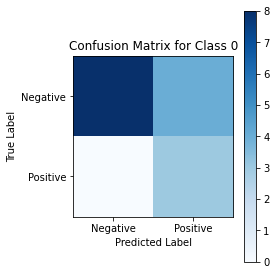

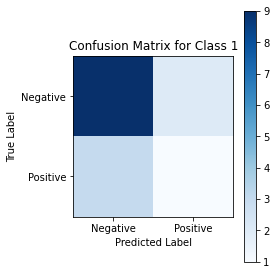

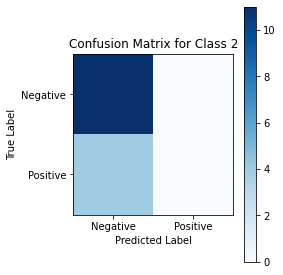

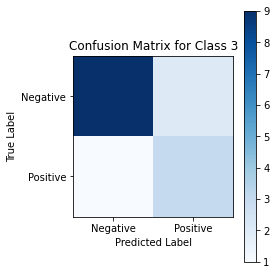

In [12]:
#AutoEncoder Decoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['group'].values[1:]

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

flattened_image_features = image_features.reshape(image_features.shape[0], -1)
X = np.concatenate([flattened_image_features, num_features], axis=1)

# Number of runs for averaging results
num_runs = 10

# Initialize list to store AUC values for each class
auc_values = [[] for _ in range(len(set(y_string)))]

# Parameters for model training
random_state = 42

# Reshape X for autoencoder input
X = X.reshape(X.shape[0], -1)

# Loop for multiple runs
for _ in range(num_runs):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_string, test_size=0.3, stratify=y_string, random_state=random_state)

    # Convert class labels to numerical labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    num_classes = len(label_encoder.classes_)

    # Create an autoencoder-decoder model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(X.shape[1], activation='sigmoid'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')



    # Calculate ROC curve and AUC for each class
    for class_index in range(num_classes):
        # Train the model
        model.fit(X_train, X_train, batch_size=32, epochs=10, verbose=0)
        # Encode and decode the test data
        encoded_X_test = model.predict(X_test)


        y_true_binary_class = (y_test_encoded == class_index).astype(int)
        y_pred_prob_class = y_pred_prob[:, class_index]
        fpr, tpr, _ = roc_curve(y_true_binary_class, y_pred_prob_class)
        roc_auc = auc(fpr, tpr)
        auc_values[class_index].append((fpr, tpr))
        print(f"Class {class_index}: ROC AUC = {roc_auc:.2f}")

model.save('Autoencoder_decoder_model.h5')

# Calculate mean ROC curve for each class
mean_fpr_tpr = []
for class_index in range(num_classes):
    fpr_values = []
    tpr_values = []
    max_len = 0  # Track the maximum length of FPR and TPR values among all runs
    for fpr, tpr in auc_values[class_index]:
        fpr_values.append(fpr)
        tpr_values.append(tpr)
        max_len = max(max_len, len(fpr), len(tpr))
    
    # Interpolate FPR and TPR values for each run to ensure they have the same length
    interp_fpr_values = [np.interp(np.linspace(0, 1, max_len), tpr, fpr) for fpr, tpr in zip(fpr_values, tpr_values)]
    interp_tpr_values = [np.interp(np.linspace(0, 1, max_len), tpr, tpr) for tpr in tpr_values]
    
    # Calculate mean FPR and TPR
    mean_fpr = np.mean(interp_fpr_values, axis=0)
    mean_tpr = np.mean(interp_tpr_values, axis=0)
    
    mean_fpr_tpr.append((mean_fpr, mean_tpr))

# Plot mean ROC curves for each class
plt.figure(figsize=(8, 6))
for class_index, (mean_fpr, mean_tpr) in enumerate(mean_fpr_tpr):
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot([0] + list(mean_fpr), [0] + list(mean_tpr), lw=2, label='ROC curve for class {} (AUC = {:.2f})'.format(class_index, mean_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curves for multiple classes using AutoEncoder Decoder')
plt.legend(loc="lower right")
plt.show()

# Initialize an empty array to store binary predictions for each class
all_pred_binary = []

# Threshold the reconstruction error for each class separately
for class_index in range(num_classes):
    
    # Reconstruction error as the prediction
    # y_pred_prob_class = np.linalg.norm(X_test - encoded_X_test, axis=1)
    # # Threshold the reconstruction error to get the predicted labels for the current class
    # threshold = np.percentile(y_pred_prob_class, 95)  # Example threshold (adjust as needed)
    # y_pred_class_binary = (y_pred_prob_class > threshold).astype(int)
    # all_pred_binary.append(y_pred_class_binary)
    y_pred_class_binary = np.argmax(y_pred_prob, axis=1)
    all_pred_binary.append(y_pred_class_binary)

# Convert the list of binary predictions to a numpy array
all_pred_binary = np.array(all_pred_binary)

# Iterate over each class and plot confusion matrix
for class_index in range(num_classes):
    # Filter true and predicted labels for the current class
    y_true_class = (y_test_encoded == class_index).astype(int)
    y_pred_class = (all_pred_binary[class_index] == class_index).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_class, y_pred_class)

    # Plot confusion matrix
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Class {class_index}')
    plt.colorbar()

    # Manually specify tick labels for a 2x2 confusion matrix
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


In [14]:
print("Data types of X_test and encoded_X_test:")
print("X_test:", X_test.dtype)
print("encoded_X_test:", encoded_X_test.dtype)

Data types of X_test and encoded_X_test:
X_test: object
encoded_X_test: float32


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16

# Load your data
excel_file_path = 'CAR_CFD_UCFD_CRI_CARD.tsv'
column_names = ['CAR', 'CFD', 'UCFD', 'CRI', 'CARD', 'group', 'image_path', 'binary_group']
df = pd.read_csv(excel_file_path, sep='\t', names=column_names)
num_features = df[['CAR', 'CFD', 'UCFD', 'CRI', 'CARD']].values
num_features = num_features[1:]
image_paths = df['image_path'].values
image_paths = image_paths[1:]
y_string = df['group'].values[1:]

# Preprocess image data
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    return img_array

images = np.array([preprocess_image(path) for path in image_paths])

# Load the VGG16 model with pretrained weights
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
image_features = vgg_model.predict(images)

# Number of runs for averaging results
num_runs = 10

# Initialize list to store AUC values for each class
auc_values = [[] for _ in range(len(set(y_string)))]

# Parameters for model training
random_state = 42

# Define U-Net model
def unet(input_size=(224, 224, 3)):
    inputs = Input(input_size)
    
    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottom
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
    # Expansive path
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
    outputs = Conv2D(3, 1, activation='sigmoid')(conv5)  # Adjust channels as needed
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Loop for multiple runs
for _ in range(num_runs):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(image_features, num_features, test_size=0.3, stratify=y_string, random_state=random_state)

    # Define U-Net model
    model = unet()

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer=Adam())

    # Train the model
    model.fit(X_train, X_train, batch_size=32, epochs=10, verbose=0)

    # Encode and decode the test data
    encoded_X_test = model.predict(X_test)

    # Calculate ROC curve and AUC for each class
    for class_index in range(num_classes):
        y_true_binary_class = (y_test_encoded == class_index).astype(int)
        y_pred_prob_class = np.linalg.norm(X_test - encoded_X_test, axis=1)  # Reconstruction error as prediction
        fpr, tpr, _ = roc_curve(y_true_binary_class, y_pred_prob_class)
        roc_auc = auc(fpr, tpr)
        auc_values[class_index].append((fpr, tpr))
        print(f"Class {class_index}: ROC AUC = {roc_auc:.2f}")

# Calculate mean ROC curve for each class
mean_fpr_tpr = []
for class_index in range(num_classes):
    fpr_values = []
    tpr_values = []
    max_len = 0  # Track the maximum length of FPR and TPR values among all runs
    for fpr, tpr in auc_values[class_index]:
        fpr_values.append(fpr)
        tpr_values.append(tpr)
        max_len = max(max_len, len(fpr), len(tpr))
    
    # Interpolate FPR and TPR values for each run to ensure they have the same length
    interp_fpr_values = [np.interp(np.linspace(0, 1, max_len), tpr, fpr) for fpr, tpr in zip(fpr_values, tpr_values)]
    interp_tpr_values = [np.interp(np.linspace(0, 1, max_len), tpr, tpr) for tpr in tpr_values]
    
    # Calculate mean FPR and TPR
    mean_fpr = np.mean(interp_fpr_values, axis=0)
    mean_tpr = np.mean(interp_tpr_values, axis=0)
    
    mean_fpr_tpr.append((mean_fpr, mean_tpr))

# Plot mean ROC curves for each class
plt.figure(figsize=(8, 6))
for class_index, (mean_fpr, mean_tpr) in enumerate(mean_fpr_tpr):
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot([0] + list(mean_fpr), [0] + list(mean_tpr), lw=2, label='ROC curve for class {} (AUC = {:.2f})'.format(class_index, mean_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curves for multiple classes using U-Net')
plt.legend(loc="lower right")
plt.show()


TypeError: pool_2d() got an unexpected keyword argument 'ws'